In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors



nDivisionsXY = 168
sLength = 84
number_of_events = 1000

def calcEventsMesh(baseDir:str, xhit, yhit):

    mesh = np.zeros((number_of_events, nDivisionsXY, nDivisionsXY))

    for enNum in range(number_of_events):

        # print("Proocessing file #", enNum)

        with open(baseDir+f"/{xhit},{yhit}/evnt_{enNum}_gamma_25GeV_{xhit},{yhit}.txt") as fileEdep:

            fileEdep.readline() # skip 3 firts lines
            fileEdep.readline()
            fileEdep.readline()

            for line in fileEdep:
                lineSplit = line.split(",")

                ix = int(lineSplit[0])
                iy = int(lineSplit[1])

                eDep = float(lineSplit[3])

                mesh[enNum, ix, iy] += eDep

    return mesh


In [41]:
# mesh = calcEventsMesh("build/eDepMaps", 3,3)



# mesh = np.mean(mesh, axis=0)

# eDepMean = np.sum(mesh)



# #################################
# ## eDep plots
# #################################
# plt.figure(figsize=(3*6.4, 3*4.8))
# plt.imshow(np.transpose(mesh)[::-1,:], extent=(-sLength, sLength, -sLength, sLength), norm=colors.LogNorm(vmin=1e-3))
# cbar = plt.colorbar()
# cbar.ax.set_ylabel("Deposited Energy [MeV]")
# plt.xlabel("x [mm]")
# plt.ylabel("y [mm]")
# ax = plt.gca()
# ax.text(0.55, 0.01, "dx = dy = {:.2f} mm".format(sLength*2/nDivisionsXY), transform=ax.transAxes, color="orange")
# ax.text(0.05, 0.01, "Mean (over events)\ndeposited energy\nis {:.2f} MeV".format(eDepMean),
#                 transform=ax.transAxes, color="orange")

In [42]:
meshs_dict = {}

for i in range(4):
    for j in range(0,i+1):

        key = f"X={i},Y={j}"

        print(key)

        meshs_dict[key] = calcEventsMesh("build/eDepMaps", i,j)



X=0,Y=0
X=1,Y=0
X=1,Y=1
X=2,Y=0
X=2,Y=1
X=2,Y=2
X=3,Y=0
X=3,Y=1
X=3,Y=2
X=3,Y=3


In [43]:
meshs_dict_no_fib = meshs_dict



for key, item in meshs_dict_no_fib.items():

    idxs = np.arange(3,168, 7)

    idxs_x, idxs_y = np.meshgrid(idxs, idxs)

    idxs_x = idxs_x.flatten()
    idxs_y = idxs_y.flatten()

    meshs_dict_no_fib[key][:,idxs_x,idxs_y] = 0

In [44]:
from scipy.optimize import curve_fit 

def dispHistAndGauss(ax, data):

    # n_bins = int(np.sqrt(data.size))
    n_bins = 50
    bin_size = (np.max(data) - np.min(data))/n_bins

    histCounts, edges, _ = ax.hist(data, bins = n_bins)
    binCenters = (edges[1:] + edges[:-1])/2

    gaussFunc = lambda x, A, mu, sig: A*np.exp(-(x-mu)**2/sig**2/2)
    mu = np.mean(data)
    sig = np.std(data, ddof=1)
    A = data.size/(np.sqrt(2*np.pi)*sig)*bin_size
    p0 = (A, mu, sig)

    (A, mu, sig), _ = curve_fit(gaussFunc, binCenters, histCounts , p0=p0)

    x_gauss = np.linspace(np.min(data), np.max(data), 4*n_bins)
    y_gauss = gaussFunc(x_gauss, A, mu, sig)

    ax.plot(x_gauss, y_gauss, "r", label="$\sigma={:.2e}$\n$\mu={:.2e}$".format(sig, mu))
    ax.set_xlabel("$(\\tilde{E}_{ecs} - E_{ecs})/E_0$")
    ax.legend()

    return mu, sig

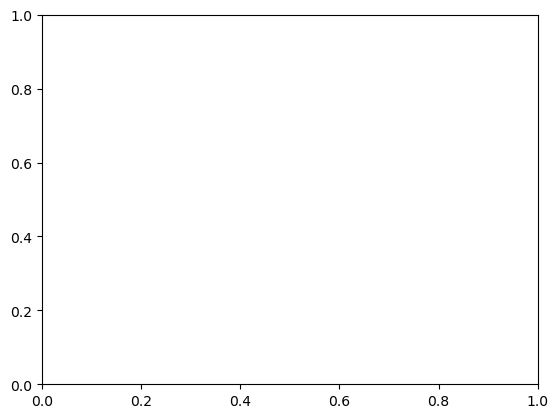

In [45]:
mean_measured  = []
sigma_measured = []

ab = np.linspace(0, 0.15, 16)

for amplitude in list(ab):

    eDep_uniform_source = np.array([])

    for i in range(7):
        for j in range(7):

            x = np.abs(i-3)
            y = np.abs(j-3)

            if y > x: x,y = y,x

            key = f"X={x},Y={y}"


            eDeps = meshs_dict_no_fib[key]

            x = np.linspace(-sLength+0.5, sLength-0.5, nDivisionsXY)

            X, Y = np.meshgrid(x, x)

            X = np.expand_dims(X, axis = 0)
            Y = np.expand_dims(Y, axis = 0)

            eDeps = eDeps*(1-amplitude*np.cos(2*np.pi * X / 7) - amplitude*np.cos(2*np.pi * Y / 7))

            eDeps = np.sum(eDeps, axis=-1)
            eDeps = np.sum(eDeps, axis=-1)

            eDep_uniform_source = np.concatenate([eDep_uniform_source, eDeps ])

    _, sigma = dispHistAndGauss(plt.gca(), eDep_uniform_source[eDep_uniform_source > 22500])
    
    mu = np.mean(eDep_uniform_source)/1000

    mean_measured.append(mu)
    sigma_measured.append(sigma)

plt.gca().clear()

Amplitude,	 mu [GeV], 		sigma [MeV]
0.0,     	 24.062567050560837,	93.15778829881732
0.01,     	 24.052872445093815,	89.59136652794409
0.02,     	 24.043177839626797,	101.57205178636966
0.03,     	 24.033483234159778,	125.41215744072274
0.04,     	 24.023788628692763,	154.8567591937857
0.05,     	 24.014094023225745,	185.71843923563102
0.06,     	 24.004399417758727,	216.33282410696722
0.07,     	 23.994704812291715,	248.97229491633317
0.08,     	 23.985010206824697,	281.8275858200488
0.09,     	 23.97531560135768,	317.30968007966544
0.1,     	 23.965620995890667,	353.2153915962755
0.11,     	 23.955926390423645,	389.47608831022484
0.12,     	 23.946231784956623,	428.7884215565426
0.13,     	 23.936537179489612,	469.67834395310285
0.14,     	 23.926842574022594,	511.0355646946922
0.15,     	 23.91714796855557,	554.662727757456


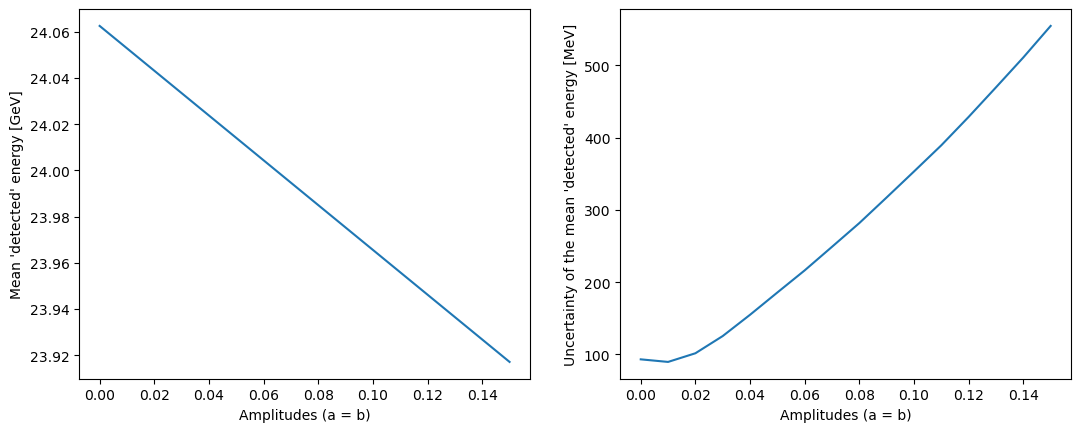

In [46]:
plt.figure(figsize = (2*6.4, 4.8))

plt.subplot(1,2,1)
# plt.errorbar(ab, mean_measured,   yerr=sigma_measured,   fmt='.', capsize=3, label="Total escaped energy")
plt.plot(ab, mean_measured)
plt.xlabel("Amplitudes (a = b)")
plt.ylabel("Mean 'detected' energy [GeV]")

plt.subplot(1,2,2)
plt.plot(ab, sigma_measured)
plt.xlabel("Amplitudes (a = b)")
plt.ylabel("Uncertainty of the mean 'detected' energy [MeV]")

print("Amplitude,\t mu [GeV], \t\tsigma [MeV]")

for amp, mu, sigma in zip(ab, mean_measured,sigma_measured):
    print(f"{amp},     \t {mu},\t{sigma}")